# **Laboratorio 11: LLM y Agentes Autónomos 🤖**

MDS7202: Laboratorio de Programación Científica para Ciencia de Datos

### **Cuerpo Docente:**

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliar: Eduardo Moya
- Ayudantes: Nicolás Ojeda, Melanie Peña, Valentina Rojas

### **Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados**

- Nombre de alumno 1: Francisca Ruiz
- Nombre de alumno 2: Valentina Zúñiga

### **Link de repositorio de GitHub:** [Repositorio](https://github.com/vazuniga1/Laboratorios)

## **Temas a tratar**

- Reinforcement Learning
- Large Language Models

## **Reglas:**

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### **Objetivos principales del laboratorio**

- Resolución de problemas secuenciales usando Reinforcement Learning
- Habilitar un Chatbot para entregar respuestas útiles usando Large Language Models.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

## **1. Reinforcement Learning (2.0 puntos)**

En esta sección van a usar métodos de RL para resolver dos problemas interesantes: `Blackjack` y `LunarLander`.

In [ ]:
!pip install -qqq gymnasium stable_baselines3
!pip install -qqq swig
!pip install -qqq gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### **1.1 Blackjack (1.0 puntos)**

<p align="center">
  <img src="https://www.recreoviral.com/wp-content/uploads/2016/08/s3.amazonaws.com-Math.gif"
" width="400">
</p>

La idea de esta subsección es que puedan implementar métodos de RL y así generar una estrategia para jugar el clásico juego Blackjack y de paso puedan ~~hacerse millonarios~~ aprender a resolver problemas mediante RL.

Comencemos primero preparando el ambiente. El siguiente bloque de código transforma las observaciones del ambiente a `np.array`:


In [ ]:
import gymnasium as gym
from gymnasium.spaces import MultiDiscrete
import numpy as np

class FlattenObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super(FlattenObservation, self).__init__(env)
        self.observation_space = MultiDiscrete(np.array([32, 11, 2]))

    def observation(self, observation):
        return np.array(observation).flatten()

# Create and wrap the environment
env = gym.make("Blackjack-v1")
env = FlattenObservation(env)

#### **1.1.1 Descripción de MDP (0.2 puntos)**

Entregue una breve descripción sobre el ambiente [Blackjack](https://gymnasium.farama.org/environments/toy_text/blackjack/) y su formulación en MDP, distinguiendo de forma clara y concisa los estados, acciones y recompensas.

El entorno de Blackjack simula el clásico juegos de cartas siguiendo una formulación de Proceso de Decisión de Markov. El objetivo es maximizar la recompensa acumulada, aprendiendo cuándo tomar cada acción para generar más frecuentemente frente a las estrategias del dealer. Presenta los siguientes componentes:

*   Estados (S): Representa la configuración actual del juego y viene representado por una tupla (suma_jugador, carta_dealer, as_usable), en donde cada uno significa:
  - suma_jugador: La suma de las cartas del jugador (máximo 21 sin pasarse)
  - carta_dealer: El valor de la carta visible del dealer.
  - as_usable: Un valor booleano que indica si el jugador tiene un As "usable"

* Acciones (A):
  - Stand (0): Mantener la suma actual de cartas y pasar el turno al dealer.
  - Hit (1): Solicitar una carta adicional

* Recompensas (R):
  - +1: El jugador gana
  - -1: El jugador pierde
  - 0: Empate



#### **1.1.2 Generando un Baseline (0.2 puntos)**

Simule un escenario en donde se escojan acciones aleatorias. Repita esta simulación 5000 veces y reporte el promedio y desviación de las recompensas. ¿Cómo calificaría el performance de esta política? ¿Cómo podría interpretar las recompensas obtenidas?

In [ ]:
# Se simula escenario de acciones aleatorias

def scenary_blackjack(env):
    # Inicializamos reward del escenario
    scenary_reward = 0
    finish = False

    # Se reinicia env
    obs = env.reset()

    # Se sigue realizando mientras no haya terminado la acción
    while not finish:
        action = env.action_space.sample() # acción aleatoria
        obs, reward, finish, _, _ = env.step(action) #action
        scenary_reward += reward

    return scenary_reward

In [ ]:
# Se repite la simulacion 5000 veces
n_times = 5_000
rewards = [scenary_blackjack(env) for _ in range(n_times)]

print(f"Promedio de recompensas: {np.mean(rewards)}")
print(f"Desviación de recompensas: {np.std(rewards)}")

Promedio de recompensas: -0.3896
Desviación de recompensas: 0.9001176811950757


Es posible observar que el promedio de recompensas es negativo, indicando que esta aleatoridad piede más partidas de las que gana. Por otro lado, la desviación estándar nos sugiere una variabilidad alta, lo cual es esperado dado el enfoque aleatorio.

Así, vemos que la política aleatoria es muy infeciente, ya que no toma decisiones inteligentes basadas en el estado del juego.

#### **1.1.3 Entrenamiento de modelo (0.2 puntos)**

A partir del siguiente [enlace](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html), escoja un modelo de `stable_baselines3` y entrenelo para resolver el ambiente `Blackjack`.

In [ ]:
from stable_baselines3 import PPO

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.36     |
|    ep_rew_mean     | -0.55    |
| time/              |          |
|    fps             | 725      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.31        |
|    ep_rew_mean          | -0.35       |
| time/                   |             |
|    fps                  | 557         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018492615 |
|    clip_fraction        | 0.353       |
|    clip_range           | 0.2         |
|    entropy_loss   

In [ ]:
model.save("blackjack_model")

#### **1.1.4 Evaluación de modelo (0.2 puntos)**

Repita el ejercicio 1.1.2 pero utilizando el modelo entrenado. ¿Cómo es el performance de su agente? ¿Es mejor o peor que el escenario baseline?

In [ ]:
# Se simula escenario de acciones aleatorias

def scenary_blackjack(env, model):
    # Inicializamos reward del escenario
    scenary_reward = 0
    finish = False

    # Se reinicia env
    obs, _ = env.reset()

    # Se sigue realizando mientras no haya terminado la acción
    while not finish:
        action, _ = model.predict(obs, deterministic=True)

        obs, reward, finish, _, _ = env.step(action) #action
        scenary_reward += reward

    return scenary_reward

In [ ]:
# se inicializa modelo
model = PPO.load("blackjack_model")

# Se repite la simulacion 5000 veces
n_times = 5_000
rewards = [scenary_blackjack(env, model) for _ in range(n_times)]

print(f"Promedio de recompensas: {np.mean(rewards)}")
print(f"Desviación de recompensas: {np.std(rewards)}")

Promedio de recompensas: -0.0902
Desviación de recompensas: 0.9610743779749826


Si bien el promedio de recompensas sigue siendo negativo, se observa que el resultado del modelo entrenado tiene un valor más cercano a 0, indicando que el agente toma mejores decisiones en comparación con la política aleatoria. Se puede concluir que si bien el modelo mejora el rendimiento, aún no es una estrategia completamente óptima.

#### **1.1.5 Estudio de acciones (0.2 puntos)**

Genere una función que reciba un estado y retorne la accion del agente. Luego, use esta función para entregar la acción escogida frente a los siguientes escenarios:

- Suma de cartas del agente es 6, dealer muestra un 7, agente no tiene tiene un as
- Suma de cartas del agente es 19, dealer muestra un 3, agente tiene tiene un as

¿Son coherentes sus acciones con las reglas del juego?

Hint: ¿A que clase de python pertenecen los estados? Pruebe a usar el método `.reset` para saberlo.

In [ ]:
def state_to_action(state, model):
    action, _ = model.predict(state, deterministic=True)
    return action

In [ ]:
# generación escenarios
state_1 = [6, 7, 0]
state_2 = [19, 3, 1]

# obtenemos action
action_1 = state_to_action(state_1, model)
action_2 = state_to_action(state_2, model)

print(f"Escenario 1: {action_1}")
print(f"Escenario 2: {action_2}")

Escenario 1: 0
Escenario 2: 0


Del primer escenario vemos que no se obtiene una acción coherente, pues al tener una suma tan baja y sin as usable, lo ideal sería pedir una carta (1).

Del segundo escenario si se obtiene una acción coherente, pues con 19 puntos y un as usable, al jugador le conviene plantarse al tener una buena mano (0).




### **1.2 LunarLander**

<p align="center">
  <img src="https://i.redd.it/097t6tk29zf51.jpg"
" width="400">
</p>

Similar a la sección 2.1, en esta sección usted se encargará de implementar una gente de RL que pueda resolver el ambiente `LunarLander`.

Comencemos preparando el ambiente:


In [ ]:
import gymnasium as gym
env = gym.make("LunarLander-v3", render_mode = "rgb_array", continuous = True) # notar el parámetro continuous = True

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Noten que se especifica el parámetro `continuous = True`. ¿Que implicancias tiene esto sobre el ambiente?

R: El parámetro nos indica que el espacio de acciones cambia de ser discreto a continuo, en el rango [-1,1]. Esto significa que el agente puede ajustar con más precisión la magnitud de los motores principales y laterales, añadiendo mayor realismo al entorno.


Además, se le facilita la función `export_gif` para el ejercicio 2.2.4:

In [ ]:
import imageio
import numpy as np

def export_gif(model, n = 5):
  '''
  función que exporta a gif el comportamiento del agente en n episodios
  '''
  images = []
  for episode in range(n):
    obs = model.env.reset()
    img = model.env.render()
    done = False
    while not done:
      images.append(img)
      action, _ = model.predict(obs)
      obs, reward, done, info = model.env.step(action)
      img = model.env.render(mode="rgb_array")

  imageio.mimsave("agent_performance.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

#### **1.2.1 Descripción de MDP (0.2 puntos)**

Entregue una breve descripción sobre el ambiente [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) y su formulación en MDP, distinguiendo de forma clara y concisa los estados, acciones y recompensas. ¿Como se distinguen las acciones de este ambiente en comparación a `Blackjack`?

Nota: recuerde que se especificó el parámetro `continuous = True`

El ambiente LunarLander es un problema de optimización de trayectoria donde el objetivo es controlar un módulo lunar para que aterrice de manera segura en una plataforma específica.

* Estados:El estado es un vector de 8 dimensiones que describe el sistema en un momento dado:
  - Posición x, y del módulo lunar.
  - Velocidades lineales x,y
  - Angulo de orientación del módulo
  - Velocidad angular
  - Dos valores booleanos que indican si las patas izq y der están en contacto con el suelo.

* Acciones:
  - 0: Hacer nada
  - 1: Encender el propulsor de orientación izquierda
  - 2: Encender el propulsor central
  - 3: Encender el propulsor de orientación derecha

* Recompensas: La recompensa acumulada se calcula en función de:
  - Proximidad al objetivo: mayor recompensa por estar más cerca de la plataforma de aterrizaje
  - Velocidad: penalización por velocidades altas y recompensa por velocidades controladas.
  - Orientación: penalización por inclinación excesiva.
  - Contacto de las patas: +10 puntos por cada pata en contacto con el suelo
  - Penalización por uso de combustible: -0.03 puntos por motor lateral y -0.3 puntos por el motor principal.
  - Finalización del episodio: +100 puntos si el modulo aterriza correctamente, -100 punto si el módulo choca.
  - Se considera que el aterrizaje es solución si se obtienen al menos 200 puntos.

En cuanto a su diferencia con Blackjack, estas se distinguen en la cantidad de acciones disponibles. En el caso de Blackjack, solo existen 2 posibilidades: quedarse o pedir otra carta, mientras que en el caso de LunarLander son 4.



#### **1.2.2 Generando un Baseline (0.2 puntos)**

Simule un escenario en donde se escojan acciones aleatorias. Repita esta simulación 10 veces y reporte el promedio y desviación de las recompensas. ¿Cómo calificaría el performance de esta política?

In [ ]:
# Parámetros de la simulación
n_simulations = 10
total_rewards = []

# Se realiza la simulación
for i in range(n_simulations):
  obs = env.reset()
  episode_rewards = 0
  done = False

  while not done:
    action = env.action_space.sample()
    obs, reward, done, _, _ = env.step(action)
    episode_rewards += reward

    total_rewards.append(episode_rewards)

# Se calcula el promedio y desviación estándar de las recompensas
mean_reward = np.mean(total_rewards)
std_reward = np.std(total_rewards)

print(f"Promedio de recompensas: {mean_reward}")
print(f"Desviación estándar de recompensas: {std_reward}")

Promedio de recompensas: -55.68367864203107
Desviación estándar de recompensas: 58.96074742590754


¿Cómo calificaría el performance de esta política?

R: De los resultados obtenidos podemos calificar la performance como no satisfactoria. Esto debido a que el promedio de recomensas de -55.68 nos indica que el agente no está logrando aterrizar el módulo de manera existosa. Además la desviación estándar es bastante alta, lo que implica que la variabilidad en las recompensas es grande.

#### **1.2.3 Entrenamiento de modelo (0.2 puntos)**

A partir del siguiente [enlace](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html), escoja un modelo de `stable_baselines3` y entrenelo para resolver el ambiente `LunarLander` **usando 10000 timesteps de entrenamiento**.

In [ ]:
# Se inicializa el modelo PPO
modelo = PPO("MlpPolicy", env, verbose=1)

# Se entrena el modelo
modelo.learn(total_timesteps=10000)
modelo.save("PPO_lunarlander")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | -266     |
| time/              |          |
|    fps             | 942      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 107          |
|    ep_rew_mean          | -250         |
| time/                   |              |
|    fps                  | 731          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0060451822 |
|    clip_fraction        | 0.0419       |
|    clip_range           | 0.2          |
|    en

#### **1.2.4 Evaluación de modelo (0.2 puntos)**

Repita el ejercicio 1.2.2 pero utilizando el modelo entrenado. ¿Cómo es el performance de su agente? ¿Es mejor o peor que el escenario baseline?

In [ ]:
# Parámetros de la simulación
n_simulations = 10
total_rewards = []

# Se realiza la simulación con el modelo entrenado
for i in range(n_simulations):
  obs, _ = env.reset()
  episode_rewards = 0
  done = False

  while not done:
    action, _ = modelo.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    episode_rewards += reward

    total_rewards.append(episode_rewards)

# Se calcula el promedio y desviación estándar de las recompensas
mean_reward = np.mean(total_rewards)
std_reward = np.std(total_rewards)

print(f"Promedio de recompensas: {mean_reward}")
print(f"Desviación estándar de recompensas: {std_reward}")

Promedio de recompensas: -16.239532835936085
Desviación estándar de recompensas: 33.8100504009616


¿Cómo es el performance de su agente? ¿Es mejor o peor que el escenario baseline?

R: De los resultados obtenidos vemos que, si bien el modelo presenta mejores resultados que antes, su performance sigue siendo baja debido a que el promedio de recompensas aún es un valor negativo. Por otro lado, vemos que la desviación estándar también disminyó, indicando que la variabilidad bajó.

#### **1.2.5 Optimización de modelo (0.2 puntos)**

Repita los ejercicios 1.2.3 y 1.2.4 hasta obtener un nivel de recompensas promedio mayor a 50. Para esto, puede cambiar manualmente parámetros como:
- `total_timesteps`
- `learning_rate`
- `batch_size`

Una vez optimizado el modelo, use la función `export_gif` para estudiar el comportamiento de su agente en la resolución del ambiente y comente sobre sus resultados.

Adjunte el gif generado en su entrega (mejor aún si además adjuntan el gif en el markdown).

In [ ]:
# 1.2.3 Entrenamiento del modelo con parámetroz optimizados
modelo_opti = PPO("MlpPolicy", env, verbose=0, learning_rate=0.0001, batch_size=32, seed = 555)
modelo_opti.learn(total_timesteps= 1000000)

modelo_opti.save("PPO_lunarlander_optimizado")

In [ ]:
# Se repite 1.2.4 con el modelo optimizado
# Parámetros de la simulación
n_simulations = 10
total_rewards = []

# Se realiza la simulación con el modelo entrenado
for i in range(n_simulations):
  obs, _ = env.reset()
  episode_rewards = 0
  done = False

  while not done:
    action, _ = modelo_opti.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    episode_rewards += reward

    total_rewards.append(episode_rewards)

# Se calcula el promedio y desviación estándar de las recompensas
mean_reward = np.mean(total_rewards)
std_reward = np.std(total_rewards)

print(f"Promedio de recompensas: {mean_reward}")
print(f"Desviación estándar de recompensas: {std_reward}")

Promedio de recompensas: 59.374431513826266
Desviación estándar de recompensas: 31.070379958670223


In [ ]:
import imageio

def export_gif(model_opti, n=5):
    images = []
    for episode in range(n):
        obs = modelo_opti.env.reset()
        img = modelo_opti.env.render()
        done = False
        while not done:
            images.append(img)
            action, _ = modelo_opti.predict(obs)
            obs, reward, done, info = modelo_opti.env.step(action)
            img = modelo_opti.env.render(mode="rgb_array")

    imageio.mimsave("agent_performance.gif", [np.array(img) for i, img in enumerate(images) if i % 2 == 0], fps=29)

# Se exporta el gif del agente optimizado
export_gif(modelo_opti)


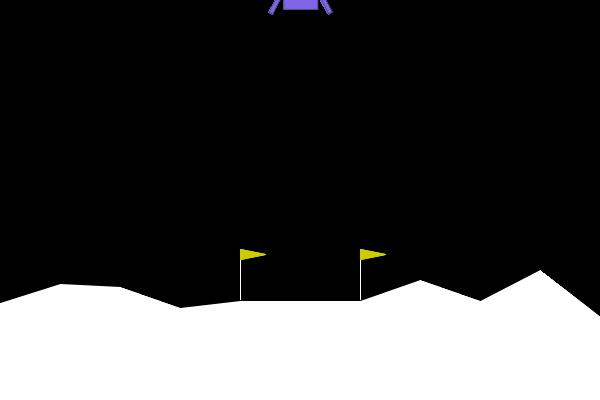

In [ ]:
from IPython.display import Image
Image(filename="agent_performance.gif")

A partir de los resultados obtenidos, se puede concluir que al entrenar el modelo con una mayor cantidad de pasos, se logra un desempeño significativamente mejor, alcanzando un promedio de recompensa superior a 50. Esto se refleja claramente en el gif generado, donde la mayoría de los aterrizajes se realizan de manera suave y dentro de los límites.

## **2. Large Language Models (4.0 puntos)**

En esta sección se enfocarán en habilitar un Chatbot que nos permita responder preguntas útiles a través de LLMs.

### **2.0 Configuración Inicial**

<p align="center">
  <img src="https://media1.tenor.com/m/uqAs9atZH58AAAAd/config-config-issue.gif"
" width="400">
</p>

Como siempre, cargamos todas nuestras API KEY al entorno:

In [1]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

Enter your Google AI API key: ··········
Enter your Tavily API key: ··········


### **2.1 Retrieval Augmented Generation (1.5 puntos)**

<p align="center">
  <img src="https://y.yarn.co/218aaa02-c47e-4ec9-b1c9-07792a06a88f_text.gif"
" width="400">
</p>

El objetivo de esta subsección es que habiliten un chatbot que pueda responder preguntas usando información contenida en documentos PDF a través de **Retrieval Augmented Generation.**

#### **2.1.1 Reunir Documentos (0 puntos)**

Reuna documentos PDF sobre los que hacer preguntas siguiendo las siguientes instrucciones:
  - 2 documentos .pdf como mínimo.
  - 50 páginas de contenido como mínimo entre todos los documentos.
  - Ideas para documentos: Documentos relacionados a temas académicos, laborales o de ocio. Aprovechen este ejercicio para construir algo útil y/o relevante para ustedes!
  - Deben ocupar documentos reales, no pueden utilizar los mismos de la clase.
  - Deben registrar sus documentos en la siguiente [planilla](https://docs.google.com/spreadsheets/d/1Hy1w_dOiG2UCHJ8muyxhdKPZEPrrL7BNHm6E90imIIM/edit?usp=sharing). **NO PUEDEN USAR LOS MISMOS DOCUMENTOS QUE OTRO GRUPO**
  - **Recuerden adjuntar los documentos en su entrega**.

In [2]:
%pip install --upgrade --quiet PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.5 MB/s eta 0:00:00


In [3]:
!wget 'https://docs.google.com/uc?export=download&id=1Pf75s4UM3ziriMZBMW_AGJL5giQhGGC8' -O BLIP-2.pdf

--2024-11-21 22:16:16--  https://docs.google.com/uc?export=download&id=1Pf75s4UM3ziriMZBMW_AGJL5giQhGGC8
Resolving docs.google.com (docs.google.com)... 142.251.107.101, 142.251.107.102, 142.251.107.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.107.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Pf75s4UM3ziriMZBMW_AGJL5giQhGGC8&export=download [following]
--2024-11-21 22:16:16--  https://drive.usercontent.google.com/download?id=1Pf75s4UM3ziriMZBMW_AGJL5giQhGGC8&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737540 (6.4M) [application/octet-stream]
Saving to: ‘BLIP-2.pdf’

BLIP-2.pdf          100%[===================>]   6.42M  --.-KB/s    i

In [4]:
!wget 'https://docs.google.com/uc?export=download&id=1yiM5Y1X7kMqGhv7RPfaxbaXM3nYl25N4' -O CLIP.pdf

--2024-11-21 22:16:21--  https://docs.google.com/uc?export=download&id=1yiM5Y1X7kMqGhv7RPfaxbaXM3nYl25N4
Resolving docs.google.com (docs.google.com)... 142.251.107.101, 142.251.107.102, 142.251.107.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.107.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1yiM5Y1X7kMqGhv7RPfaxbaXM3nYl25N4&export=download [following]
--2024-11-21 22:16:21--  https://drive.usercontent.google.com/download?id=1yiM5Y1X7kMqGhv7RPfaxbaXM3nYl25N4&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6814767 (6.5M) [application/octet-stream]
Saving to: ‘CLIP.pdf’

CLIP.pdf            100%[===================>]   6.50M  --.-KB/s    in 

In [5]:
import PyPDF2

doc_paths = ["BLIP-2.pdf", "CLIP.pdf"] # rellenar con los path a sus documentos

assert len(doc_paths) >= 2, "Deben adjuntar un mínimo de 2 documentos"

total_paginas = sum(len(PyPDF2.PdfReader(open(doc, "rb")).pages) for doc in doc_paths)
assert total_paginas >= 50, f"Páginas insuficientes: {total_paginas}"

#### **2.1.2 Vectorizar Documentos (0.2 puntos)**

Vectorice los documentos y almacene sus representaciones de manera acorde.

In [6]:
%pip install --upgrade --quiet faiss-cpu langchain_community pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00


In [7]:
%pip install --upgrade --quiet  langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.6 MB/s eta 0:00:00


##### Carga LLM

In [8]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash", # modelo de lenguaje
    temperature=0, # probabilidad de "respuestas creativas"
    max_tokens=None, # sin tope de tokens
    timeout=None, # sin timeout
    max_retries=2, # número máximo de intentos
)

llm

ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), temperature=0.0, max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7c3f9c4fc160>, default_metadata=())

In [9]:
from langchain_community.document_loaders import PyPDFLoader

docs = []
for doc_path in doc_paths:
  loader = PyPDFLoader(doc_path) # inicializar loader de PDF
  doc = loader.load() # cargar documento
  docs.extend(doc) # agregar a lista de documentos

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import FAISS

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50) # inicializamos splitter
splits = text_splitter.split_documents(docs) # dividir documentos en chunks

embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001") # inicializamos los embeddings
vectorstore = FAISS.from_documents(documents=splits, embedding=embedding) # vectorizacion y almacenamiento

#### **2.1.3 Habilitar RAG (0.3 puntos)**

Habilite la solución RAG a través de una *chain* y guárdela en una variable.

In [11]:
retriever = vectorstore.as_retriever(search_type="similarity", # método de búsqueda
                                     search_kwargs={"k": 3}, # n° documentos a recuperar
                                     )
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# se une todo en una chain
retriever_chain = retriever | format_docs # chain

#### **2.1.4 Verificación de respuestas (0.5 puntos)**

Genere un listado de 3 tuplas ("pregunta", "respuesta correcta") y analice la respuesta de su solución para cada una. ¿Su solución RAG entrega las respuestas que esperaba?

Ejemplo de tupla:
- Pregunta: ¿Quién es el presidente de Chile?
- Respuesta correcta: El presidente de Chile es Gabriel Boric

In [12]:
from langchain_core.prompts import PromptTemplate

rag_template = '''
Eres un asistente experto en BLIP-2 y CLIP, ambos modelos de lenguaje multimodal.
Tu único rol es contestar preguntas del usuario a partir de información relevante que te sea proporcionada.
Responde siempre de la forma más completa posible y usando toda la información entregada.
Responde sólo lo que te pregunten a partir de la información relevante, NUNCA inventes una respuesta.

Información relevante: {context}
Pregunta: {question}
Respuesta útil:
'''

rag_prompt = PromptTemplate.from_template(rag_template)

In [13]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

rag_chain = (
    {
        "context": retriever_chain, # context lo obtendremos del retriever_chain
        "question": RunnablePassthrough(), # question pasará directo hacia el prompt
    }
    | rag_prompt # prompt con las variables question y context
    | llm # llm recibe el prompt y responde
    | StrOutputParser() # recuperamos sólo la respuesta
)

In [14]:
# se genera listado de 3 tuplas, de ("pregunta", "respuesta correcta") y se compara con respuesta del modelo

vqa = [('Qué es BLIP-2?', 'Es un modelo de lenguaje multimodal capaz de procesar imagenes y texto de forma simultanea, es capaz de contestar preguntas sobre imagenes o generar texto sobre estas'),
       ('Qué tipo de aprendizaje se utiliza para entrenar CLIP?', 'aprendizaje supervisado - Contrastive Learning'),
       ('Qué es el Q-Former?', 'Querying Transformer es el modulo donde se extraen las caracteristicas más relevantes de las imagenes para ser utilizadas en el LLM')]

for qa in vqa:
    question, answer = qa
    response = rag_chain.invoke(question)
    print(f'Pregunta: {question}')
    print(f'Respuesta correcta: {answer}')
    print(f'Respuesta del modelo: {response}')

Pregunta: Qué es BLIP-2?
Respuesta correcta: Es un modelo de lenguaje multimodal capaz de procesar imagenes y texto de forma simultanea, es capaz de contestar preguntas sobre imagenes o generar texto sobre estas
Respuesta del modelo: BLIP-2 es un modelo de lenguaje multimodal que alcanza resultados de vanguardia en los conjuntos de datos VQAv2 y GQA.  Supera a Flamingo80B en un 8.7% en VQAv2, a pesar de tener 54 veces menos parámetros entrenables.  Su estrategia de entrenamiento utiliza codificadores de imágenes preentrenados congelados y modelos de lenguaje grandes congelados,  uniéndolos mediante un "Querying Transformer" (Q-Former) ligero, preentrenado en dos etapas. La primera etapa inicia el aprendizaje de la representación visión-lenguaje desde un codificador de imagen congelado, y la segunda etapa inicia el aprendizaje generativo de visión a lenguaje desde un modelo de lenguaje congelado.  BLIP-2 es computacionalmente eficiente debido al uso de modelos unimodales congelados y un

Se puede observar que las respuestas obtenidas son correctas, ya que esto es lo que efectivamente explican ambos papers. Aunque para el primer caso, la definición resulta muy tecnica debido a que compara con otros tipos de modelos en lugar de definir lo solicitado.

#### **2.1.5 Sensibilidad de Hiperparámetros (0.5 puntos)**

Extienda el análisis del punto 2.1.4 analizando cómo cambian las respuestas entregadas cambiando los siguientes hiperparámetros:
- `Tamaño del chunk`. (*¿Cómo repercute que los chunks sean mas grandes o chicos?*)
- `La cantidad de chunks recuperados`. (*¿Qué pasa si se devuelven muchos/pocos chunks?*)
- `El tipo de búsqueda`. (*¿Cómo afecta el tipo de búsqueda a las respuestas de mi RAG?*)

In [15]:
# ahora para vectorizar se varia la cantidad de chunks (tamaño) y el tipo de busqueda
def sensibility(docs, chunks, type_search):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunks, chunk_overlap=50) # inicializamos splitter
    splits = text_splitter.split_documents(docs) # dividir documentos en chunks

    embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001") # inicializamos los embeddings
    vectorstore = FAISS.from_documents(documents=splits, embedding=embedding) # vectorizacion y almacenamiento

    retriever = vectorstore.as_retriever(search_type=type_search, # método de búsqueda
                                     search_kwargs={"k": 3}, # n° documentos a recuperar
                                     )
    retriever_chain = retriever | format_docs # chain

    rag_template = '''
    Eres un asistente experto en modelos de lenguaje multimodal.
    Tu único rol es contestar preguntas del usuario a partir de información relevante que te sea proporcionada.
    Responde siempre de la forma más completa posible y usando toda la información entregada.
    Responde sólo lo que te pregunten a partir de la información relevante, NUNCA inventes una respuesta.

    Información relevante: {context}
    Pregunta: {question}
    Respuesta útil:
    '''

    rag_prompt = PromptTemplate.from_template(rag_template)

    rag_chain = (
    {
        "context": retriever_chain, # context lo obtendremos del retriever_chain
        "question": RunnablePassthrough(), # question pasará directo hacia el prompt
    }
    | rag_prompt # prompt con las variables question y context
    | llm # llm recibe el prompt y responde
    | StrOutputParser() # recuperamos sólo la respuesta
    )

    vqa = [('Qué es BLIP-2?', 'Es un modelo de lenguaje multimodal capaz de procesar imagenes y texto de forma simultanea, es capaz de contestar preguntas sobre imagenes o generar texto sobre estas'),
       ('Qué tipo de aprendizaje se utiliza para entrenar CLIP?', 'aprendizaje supervisado - Contrastive Learning'),
       ('Qué es el Q-Former?', 'Querying Transformer es el modulo donde se extraen las caracteristicas más relevantes de las imagenes para ser utilizadas en el LLM')]

    for qa in vqa:
        question, answer = qa
        response = rag_chain.invoke(question)
        print(f'Pregunta: {question}')
        print(f'Respuesta correcta: {answer}')
        print(f'Respuesta del modelo: {response}')

In [16]:
# variamos a 1000 chunks
sensibility(docs, 1000, "similarity")

Pregunta: Qué es BLIP-2?
Respuesta correcta: Es un modelo de lenguaje multimodal capaz de procesar imagenes y texto de forma simultanea, es capaz de contestar preguntas sobre imagenes o generar texto sobre estas
Respuesta del modelo: BLIP-2 es un nuevo método de pre-entrenamiento lenguaje-imagen que utiliza modelos unimodales pre-entrenados congelados.  Para superar la brecha entre modalidades, BLIP-2 utiliza un "Q-Former"  y una capa totalmente conectada para adaptar la salida del codificador de imagen a la entrada del Modelo de Lenguaje Grande (LLM) congelado, ya sea un LLM basado en decodificador (como OPT) o un LLM basado en codificador-decodificador (como FlanT5).  A diferencia de métodos existentes como Frozen y Flamingo, BLIP-2 logra un rendimiento superior con un menor coste computacional al aprovechar eficazmente codificadores de imagen y LLMs congelados para diversas tareas de visión-lenguaje.

Pregunta: Qué tipo de aprendizaje se utiliza para entrenar CLIP?
Respuesta correct

In [17]:
sensibility(docs, 250, "mmr")

Pregunta: Qué es BLIP-2?
Respuesta correcta: Es un modelo de lenguaje multimodal capaz de procesar imagenes y texto de forma simultanea, es capaz de contestar preguntas sobre imagenes o generar texto sobre estas
Respuesta del modelo: BLIP-2 es un modelo que alcanza el estado del arte en varias tareas de visión-lenguaje, incluyendo respuesta a preguntas visuales, generación de subtítulos de imágenes y recuperación de texto-imagen.  Utiliza una etapa de aprendizaje de representación y una etapa de aprendizaje generativo.  Además, gracias al uso de modelos unimodales congelados y un Q-Former ligero, es más eficiente en cuanto a cómputo que otros modelos de vanguardia, superando a Flamingo en un 8.7% en una tarea específica.  Sin embargo, debido al uso de modelos congelados, hereda los riesgos de los LLMs, como generar lenguaje ofensivo, propagar sesgos sociales o filtrar información privada.

Pregunta: Qué tipo de aprendizaje se utiliza para entrenar CLIP?
Respuesta correcta: aprendizaje 

In [18]:
sensibility(docs, 500, "mmr")

Pregunta: Qué es BLIP-2?
Respuesta correcta: Es un modelo de lenguaje multimodal capaz de procesar imagenes y texto de forma simultanea, es capaz de contestar preguntas sobre imagenes o generar texto sobre estas
Respuesta del modelo: BLIP-2 es un modelo de lenguaje multimodal que alcanza resultados de vanguardia en los conjuntos de datos VQAv2 y GQA.  Supera a Flamingo80B en un 8.7% en VQAv2, a pesar de tener 54 veces menos parámetros entrenables.  En el conjunto de datos OK-VQA, BLIP-2 ocupa el segundo lugar después de Flamingo80B.  Se hipotetiza que esto se debe a que OK-VQA se centra más en el conocimiento del mundo abierto que en la comprensión visual.  BLIP-2 también demuestra capacidades emergentes en la generación de imágenes a texto con instrucciones de cero disparos y se considera un paso importante hacia la construcción de un agente de IA conversacional multimodal.  Su entrenamiento utiliza una estrategia de dos etapas para un Querying Transformer ligero, con el fin de cerrar

Con los resultados se observa que al aumentar el tamaño de chunk entonces el modeo resulta más preciso en su explicación, además de que al variar el tipo de busqueda (y manteniendo el tamaño de chunk) se obtienen respuestas bastantes similares. Por lo que se concluye que el modelo es bastante sensible a la variación de este parametro.

### **2.2 Agentes (1.0 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/rcqnN2aJCSEAAAAd/secret-agent-man.gif"
" width="400">
</p>

Similar a la sección anterior, en esta sección se busca habilitar **Agentes** para obtener información a través de tools y así responder la pregunta del usuario.

#### **2.2.1 Tool de Tavily (0.2 puntos)**

Generar una *tool* que pueda hacer consultas al motor de búsqueda **Tavily**.

In [19]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(max_results = 1) # inicializamos tool
tool_tavily = search

#### **2.2.2 Tool de Wikipedia (0.2 puntos)**

Generar una *tool* que pueda hacer consultas a **Wikipedia**.

*Hint: Le puede ser de ayuda el siguiente [link](https://python.langchain.com/v0.1/docs/modules/tools/).*

In [20]:
%pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=56d889d1290fce964860d26e03a0a049eaabe827217bb9be9a8abd3fdde98992
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [21]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

api_wrapper = WikipediaAPIWrapper(lang='es', top_k_results=1, doc_content_chars_max=100)
tool_wiki = WikipediaQueryRun(api_wrapper=api_wrapper)

#### **2.2.3 Crear Agente (0.3 puntos)**

Crear un agente que pueda responder preguntas preguntas usando las *tools* antes generadas. Asegúrese que su agente responda en español. Por último, guarde el agente en una variable.

In [22]:
from langchain import hub

react_prompt = hub.pull("hwchase17/react") # template de ReAct

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [23]:
from langchain.agents import create_react_agent, AgentExecutor

tools = [tool_tavily, tool_wiki]
agent = create_react_agent(llm, tools, react_prompt) # primero inicializamos el agente ReAct
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True) # lo transformamos a AgentExecutor para habilitar la ejecución de tools
agent_executor

AgentExecutor(verbose=True, agent=RunnableAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_log_to_str(x['intermediate_steps']))
})
| PromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={}, partial_variables={'tools': 'tavily_search_results_json - A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.\nwikipedia - A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.', 'tool_names': 'tavily_search_results_json, wikipedia'}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'}, template='Answer the following questions as best you can. You have access to the following tools:\

In [24]:
def response_agent(question):
  response = agent_executor.invoke({"input": question})
  print(response["output"])

#### **2.2.4 Verificación de respuestas (0.3 puntos)**

Pruebe el funcionamiento de su agente y asegúrese que el agente esté ocupando correctamente las tools disponibles. ¿En qué casos el agente debería ocupar la tool de Tavily? ¿En qué casos debería ocupar la tool de Wikipedia?

In [62]:
response_agent("En que canción de Taylor Swift se dice la frase: And I won't confess that I waited, but I let the lamp burn")



> Entering new AgentExecutor chain...
Thought: I need to find the Taylor Swift song containing the lyrics "And I won't confess that I waited, but I let the lamp burn".  A lyrics search would be the best approach.  Since I don't have access to a dedicated lyrics search engine, I'll try using a general search engine focusing on accuracy.

Action: tavily_search_results_json
Action Input: "Taylor Swift lyrics \"And I won't confess that I waited, but I let the lamp burn\""
[{'url': 'https://www.lyricsondemand.com/t/taylorswiftlyrics/peterlyrics.html', 'content': "And I won't confess that I waited, but I let the lamp burn. As the men masqueraded, I hoped you'd return. With your feet on the ground, tell me all that you'd learned. 'Cause love's never lost when perspective is earned. And you said you'd come and get me, but you were twenty-five."}]Thought: The observation shows the lyrics are from a Taylor Swift song.  The URL points to a lyrics website, which confirms this.  I can now answer 

In [ ]:
response_agent("que personaje de the office dice thats what she said?")



> Entering new AgentExecutor chain...
Thought: I need to find out which character in "The Office" (US version, I assume) frequently uses the phrase "That's what she said."  Wikipedia might have information on the show's characters and their catchphrases, but a targeted search might be more efficient.  I'll try a search engine first.

Action: tavily_search_results_json
Action Input: "which character in the office says thats what she said"
[{'url': "https://theoffice.fandom.com/wiki/That's_what_she_said", 'content': 'That\'s what she said | Dunderpedia: The Office Wiki | Fandom Dunderpedia: The Office Wiki Main Page Community Main Characters Community FANDOM Wikis Explore Wikis Community Central Sign In Sign In Register Dunderpedia: The Office Wiki Main Page Community Main Characters Community "That\'s what she said" is a joke commonly said by Michael Scott, while others in the office will occasionally say it as well. The joke is meant to be said after someone says something that a wom

Al realizar las pruebas se observa que Wikipedia funciona más cuando se requieren buscar datos más generales, en cambio Tavily funciona mejor cuando se quieren datos más especificos.

### **2.3 Multi Agente (1.5 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/r7QMJLxU4BoAAAAd/this-is-getting-out-of-hand-star-wars.gif"
" width="450">
</p>

El objetivo de esta subsección es encapsular las funcionalidades creadas en una solución multiagente con un **supervisor**.


#### **2.3.1 Generando Tools (0.5 puntos)**

Transforme la solución RAG de la sección 2.1 y el agente de la sección 2.2 a *tools* (una tool por cada uno).

In [54]:
# se genera tool
from langchain.tools import tool

@tool
def rag(question: str) -> str:
    """Return the answer"""
    return rag_chain.invoke(question)

@tool
def agent(question: str) -> str:
    """Return the answer"""
    return agent_executor.invoke({"input": question})

#### **2.3.2 Agente Supervisor (0.5 puntos)**

Habilite un agente que tenga acceso a las tools del punto anterior y pueda responder preguntas relacionadas. Almacene este agente en una variable llamada supervisor.

In [55]:
supervisor_prompt = PromptTemplate.from_template(
    """
    Eres un asistente experto en la clasificación de preguntas del usuario.
    Tu único rol es clasificar preguntas del usuario en las categorías 'BLIP-2', 'CLIP', 'Web' según el siguiente criterio:
    - 'BLIP-2': Cuando la pregunta sea relacionada con el modelo BLIP-2.
    - 'CLIP': Cuando la pregunta sea relacionada al modelo CLIP.
    - 'Web': Todo aquella pregunta que no esté contenida en las categorías anteriores.

    No respondas con más de una palabra y no incluyas.


    {question}


    Categoría:"""
)

supervisor_chain = (
    supervisor_prompt
    | llm
    | StrOutputParser()
)

In [56]:
redirect_prompt = PromptTemplate.from_template(
    """
    Eres un asistente experto en el redireccionamiento de preguntas de usuarios.
    Vas a recibir una pregunta del usuario, tu único rol es indicar que no puedes responder su pregunta y redireccionar al usuario
    para que te pregunte sobre los modelos de lenguaje multimodal CLIP o BLIP-2 o preguntas de la Web.

    Recuerda ser amable y cordial en tu respuesta.

    Pregunta: {question}
    Respuesta cordial:"""
)

redirect_chain = (
    redirect_prompt
    | llm
    | StrOutputParser()
)

In [58]:
def route_question(question):
  '''
  Recibe una pregunta de usuario.
  Rutea la pregunta al agente respectivo y responde de manera acorde.
  '''

  topic = supervisor_chain.invoke({"question": question}) # enrutamiento
  if "CLIP" in topic or "BLIP-2" in topic: # si la pregunta es sobre CLIP o BLIP-2
      return rag(question)
  elif "Web" in topic: # si la pregunta es sobre Web
      response = agent(question)
      return response['output']
  else: # de lo contrario, redireccionar pregunta
      return redirect_chain.invoke({"question": question})

#### **2.3.3 Verificación de respuestas (0.25 puntos)**

Pruebe el funcionamiento de su agente repitiendo las preguntas realizadas en las secciones 2.1.4 y 2.2.4 y comente sus resultados. ¿Cómo varían las respuestas bajo este enfoque?

In [61]:
# generamos las preguntas a realizar
questions=  ['Qué es BLIP-2?',
       'Qué tipo de aprendizaje se utiliza para entrenar CLIP?',
        'Que es el Q-Former?',
        "que personaje de the office dice thats what she said?",
        "En que canción de Taylor Swift se dice la frase: And I won't confess that I waited, but I let the lamp burn"]

for question in questions:
  print(f'Pregunta: {question}')
  response = route_question(question)
  print(f'Respuesta: {response}')

Pregunta: Qué es BLIP-2?
Respuesta: BLIP-2 es un modelo de lenguaje multimodal que alcanza resultados de vanguardia en los conjuntos de datos VQAv2 y GQA.  Supera a Flamingo80B en un 8.7% en VQAv2, a pesar de tener 54 veces menos parámetros entrenables.  Su estrategia de entrenamiento utiliza codificadores de imágenes preentrenados congelados y modelos de lenguaje grandes congelados,  uniéndolos mediante un "Querying Transformer" (Q-Former) ligero, preentrenado en dos etapas. La primera etapa inicia el aprendizaje de la representación visión-lenguaje desde un codificador de imagen congelado, y la segunda etapa inicia el aprendizaje generativo de visión a lenguaje desde un modelo de lenguaje congelado.  BLIP-2 es computacionalmente eficiente debido al uso de modelos unimodales congelados y un Q-Former ligero, superando a Flamingo en un 8.7% en VQAv2 con 54 veces menos parámetros entrenables.  Además, es un método genérico que puede aprovechar modelos unimodales más avanzados para un mej

Al obtener las respuestas, se puede observar casi todas las preguntas fueron redirigidas correctamente, con excepción de 'Que es el Q-Former?', pregunta que se dirige directamente a la web cuando deberia dirigirse a BLIP-2. En todas las demás tienen una redirección correcta.

#### **2.3.4 Análisis (0.25 puntos)**

¿Qué diferencias tiene este enfoque con la solución *Router* vista en clases? Nombre al menos una ventaja y desventaja.

La diferencia principal que se tiene con la solución Router de la clase es que aqui existe una ruta donde se pueden acceder a respuestas por internet, en cambio, en la solución Router de la clase solo se redirecciona a que no puede responder la pregunta. De esta manera una de las mayores ventajas es que el agente generado de este laboratorio deberia ser capaz de responder una gran cantidad de preguntas, lo cual puede llevar a una gran desventaja, la necesidad de una mayor cantidad de recursos ya que se accede a bases de internet, en lugar de trabajar solo con datos/documentos entregados de forma manual.

### **2.4 Memoria (Bonus +0.5 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/Gs95aiElrscAAAAd/memory-unlocked-ratatouille-critic.gif"
" width="400">
</p>

Una de las principales falencias de las soluciones que hemos visto hasta ahora es que nuestro chat no responde las interacciones anteriores, por ejemplo:

- Pregunta 1: "Hola! mi nombre es Sebastián"
  - Respuesta esperada: "Hola Sebastián! ..."
- Pregunta 2: "Cual es mi nombre?"
  - Respuesta actual: "Lo siento pero no conozco tu nombre :("
  - **Respuesta esperada: "Tu nombre es Sebastián"**

Para solucionar esto, se les solicita agregar un componente de **memoria** a la solución entregada en el punto 2.3.

**Nota: El Bonus es válido <u>sólo para la sección 2 de Large Language Models.</u>**

### **2.5 Despliegue (0 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/IytHqOp52EsAAAAd/you-get-a-deploy-deploy.gif"
" width="400">
</p>

Una vez tengan los puntos anteriores finalizados, toca la etapa de dar a conocer lo que hicimos! Para eso, vamos a desplegar nuestro modelo a través de `gradio`, una librería especializada en el levantamiento rápido de demos basadas en ML.

Primero instalamos la librería:

In [46]:
%pip install --upgrade --quiet gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.6 MB/s eta 0:00:00


Luego sólo deben ejecutar el siguiente código e interactuar con la interfaz a través del notebook o del link generado:

In [47]:
import gradio as gr
import time

def agent_response(message, history):
  '''
  Función para gradio, recibe mensaje e historial, devuelte la respuesta del chatbot.
  '''
  # get chatbot response
  response = ... # rellenar con la respuesta de su chat

  # assert
  assert type(response) == str, "output de route_question debe ser string"

  # "streaming" response
  for i in range(len(response)):
    time.sleep(0.015)
    yield response[: i+1]

gr.ChatInterface(
    agent_response,
    type="messages",
    title="Chatbot MDS7202", # Pueden cambiar esto si lo desean
    description="Hola! Soy un chatbot muy útil :)", # también la descripción
    theme="soft",
    ).launch(
        share=True, # pueden compartir el link a sus amig@s para que interactuen con su chat!
        debug = False,
        )

KeyboardInterrupt: 